In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score
from math import log
from math import exp
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV



%matplotlib inline

# Objectives

We want to fit a logistic model to predict the probability of survival from the titanic disaster

# Data Understanding

First we will read in the dataframes

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_pass = pd.read_csv('gender_submission.csv')

In [4]:
df_test_orig = pd.read_csv('test.csv')

In [5]:
df_test_orig.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Exploratory Data Analysis

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Data Preparation

We need to create a dataframe of the survivors.

In [8]:
y = df_train.pop('Survived')

We need to replace the columns that contain words with numbers that can be used by the model.

In [9]:
df_train['Sex'] = df_train['Sex'].replace('male',1)
df_train['Sex'] = df_train['Sex'].replace('female',0)

We can create indicator variables for the port where people embarked

In [10]:
location = pd.get_dummies(df_train['Embarked'])
df_train = df_train.join(location)
del df_train['Embarked']

We have NaN values for age that need to be replaced.  We will use the average age as a replacement.

In [11]:
mean = df_train['Age'].mean()
df_train.fillna({'Age':mean}, inplace=True)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S
0,1,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,1,0,0
2,3,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,0,0,1
4,5,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,0,0,1
5,6,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,0,1,0
6,7,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,0,0,1
7,8,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,0,0,1
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,0,0,1
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,1,0,0


Create a dataframe that only inclues the columns we are concerned with.

In [12]:
X = df_train[['Pclass','Sex','Age','SibSp','Parch','Fare']]

We can take a look at the dataframe that we will use to create the model to make sure everything looks good.

In [13]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63a9f63eb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f63a5e69a58>]], dtype=object)

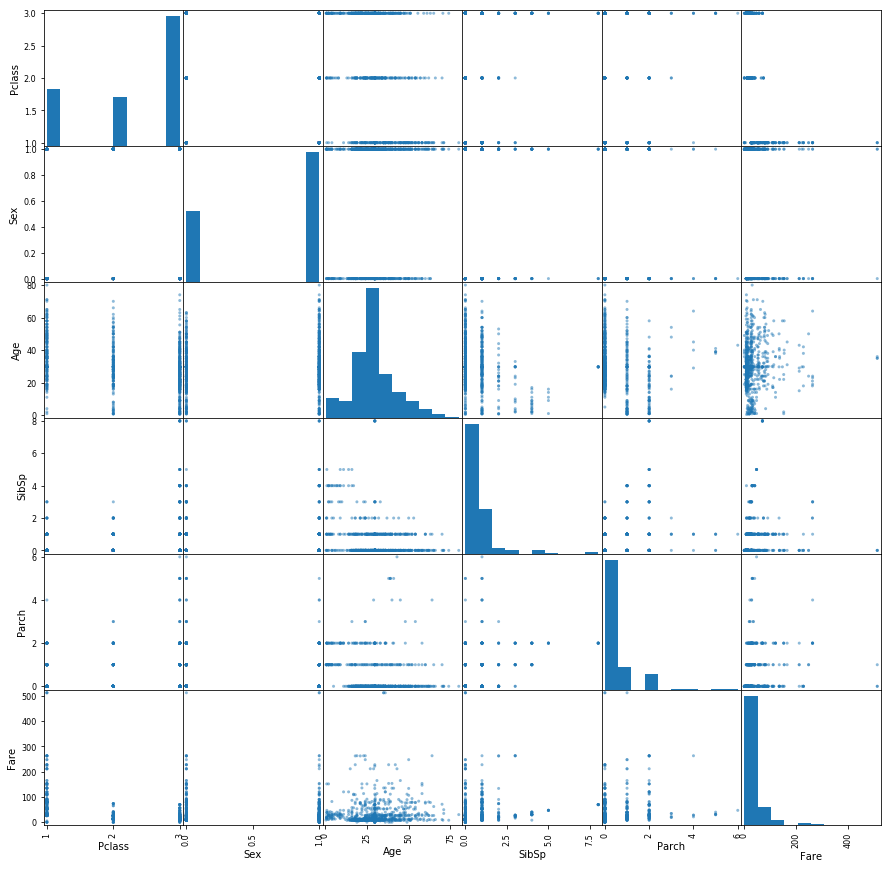

In [14]:
scatter_matrix(X, figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63a5dde9b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f63a5913ba8>]], dtype=object)

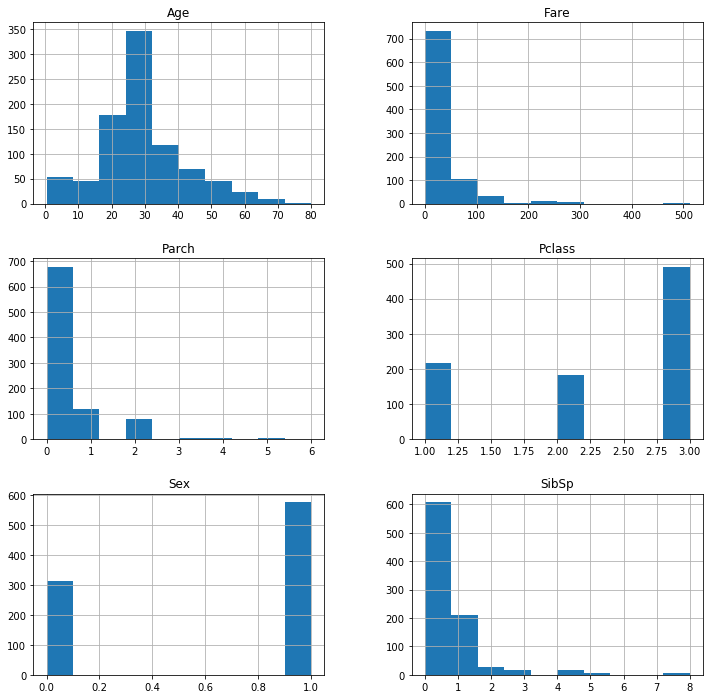

In [15]:
X.hist(figsize=(12,12))

# Modeling

For this approach we are using a boosted model.

In [16]:
boosted_model=GradientBoostingClassifier(n_estimators=5000)

In [17]:
boosted_model.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=5000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

# Evaluation

In [18]:
scores = cross_val_score(boosted_model, X, y, cv=5)
np.mean(scores)

0.79351943958887683

## Compute the log loss

Log loss is something that can be used to compare different classification models

In [19]:
boosted_model_probs = boosted_model.predict_proba(X)
log_loss_boosted= log_loss(y, boosted_model_probs)
log_loss_boosted

0.034039202096910831

## Optimize the model

In [20]:
def get_opt_n_estimators(model, X_new, y_new):
    validation_loss = np.zeros(model.get_params('n_estimators')['n_estimators'])
    for i, preds in enumerate(model.staged_predict(X_new)):
        validation_loss[i]=model.loss_(preds, y_new)
    optimal_tree=np.argmin(validation_loss)
    optimal_loss=validation_loss[optimal_tree]
    return optimal_tree, optimal_loss

In [21]:
get_opt_n_estimators(boosted_model, X, y)

(2532, 1.114867113936346)

In [45]:
param_grid = { 
    'max_depth': [2,3,5],
    'learning_rate': [0.05],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [2532]

}

CV_boosted = GridSearchCV(estimator=boosted_model, param_grid=param_grid, cv= 5)
CV_boosted.fit(X, y)
print (CV_boosted.best_params_, CV_boosted.best_score_)

{'learning_rate': 0.05, 'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 2532} 0.826038159371


In [46]:
boosted_model_opt=GradientBoostingClassifier(subsample=0.5, learning_rate=0.005, n_estimators=2532, max_depth=2, min_samples_split=3)

In [47]:
boosted_model_opt.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=3, min_weight_fraction_leaf=0.0,
              n_estimators=2532, presort='auto', random_state=None,
              subsample=0.5, verbose=0, warm_start=False)

In [48]:
boosted_model_probs = boosted_model_opt.predict_proba(X)
log_loss_boosted= log_loss(y, boosted_model_probs)
log_loss_boosted

0.3415797313311198

In [49]:
scores = cross_val_score(boosted_model_opt, X, y, cv=5)
np.mean(scores)


0.82943747169555715

# Create a test matrix

In [27]:
df_test_orig.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [28]:
df_test_orig.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [29]:
df_test_orig['Sex'] = df_test_orig['Sex'].replace('male',1)
df_test_orig['Sex'] = df_test_orig['Sex'].replace('female',0)

In [30]:
df_test = df_test_orig[['Pclass','Sex','Age','SibSp','Parch','Fare']]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass    418 non-null int64
Sex       418 non-null int64
Age       332 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      417 non-null float64
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


In [31]:
mean_age = df_train['Age'].mean()
df_test = df_test.fillna({'Age':mean_age}, inplace=True)

/home/ryan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [32]:
mean_fare = df_train['Fare'].mean()
df_test = df_test.fillna({'Fare':mean_fare}, inplace=True)

/home/ryan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


# Write results to a csv file


In [33]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass    418 non-null int64
Sex       418 non-null int64
Age       418 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      418 non-null float64
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


In [34]:
df_test.isnull().any()

Pclass    False
Sex       False
Age       False
SibSp     False
Parch     False
Fare      False
dtype: bool

In [50]:
results = boosted_model_opt.predict(df_test)

In [51]:
df_results = pd.DataFrame({'Survived': results.ravel()})

In [52]:
df_results['PassengerId']=df_test_orig['PassengerId']

In [53]:
df_results = df_results[['PassengerId', 'Survived']]

In [54]:
df_results.to_csv('results_boosted.csv', index=False)

## Kaggle score: 0.77033